In [25]:
# import cell

import xarray as xr # to work with multi-dimensional arrays
import numpy as np # to work with multi-dimensional arrays
import regionmask # to work with predefined data masks
import pandas as pd # to work with tables
import xesmf as xe # to regrid data
import glob # to find file pathways
import netCDF4 # use to save xarrays as nc files
import matplotlib
import matplotlib.pyplot as plt # for plotting
import matplotlib.colors as colors # for custom colourbars
import cartopy # use for geographic map projections
import cartopy.crs as ccrs # use for geographic map projections
import time # to add a creation timestamp to Datasets
import pickle # to save DataFrame objects efficiently
import math # perform select mathematical operations
import regionmask

### Obeservational Anomalies: Mulit-Model Ensemble

The observational anomaly is computed by negating the model output from the observation dataset. Only the present day (1981-2010) anomaly can be calculated as observational datasets do not cover the pre-industrial period (1851-1900).

In [44]:
# load in HadEX2 and multi-model ensemble tropical nights data; 2.5x3.75 lat-lon resolution
fld_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/'
hadex2_pw = fld_pw + 'AverageMap_HADEX2_TR_1981-2010_ANN_from-90to90_from-180to180.nc'
ens_pw = '/home/ucfagtj/DATA/Dissertation/Data/trop_nights/processed/ensemble_trop_nights_2_5x3_75_res.nc'
hadex2_ds = xr.open_dataset(hadex2_pw, decode_times = False).index_avg
ens_ds = xr.open_dataset(ens_pw).current_mean_ann_tn_abso # only comparing to current period

# create Dataset object to store the annual tropical nights anomaly relative to observations
obs_anom_ds = xr.Dataset()

# compute the differences between ensemble mean and obersvation mean annual tropical nights
obs_anom_ds['ens_HadEX2_anom'] = ens_ds - hadex2_ds

# add attribute information
obs_anom_ds.attrs['description'] = 'mulit-model ensemble annual tropical nights anomaly relative to' + \
                                   ' HadEX2 annual tropical nights observations'
obs_anom_ds.attrs['period'], obs_anom_ds.attrs['years_sampled'] = '1981-2010', '30'
obs_anom_ds.attrs['resolution'], obs_anom_ds.attrs['created_on'] = 'lat-lon: 2.5x3.75 degrees', time.ctime()

# save Dataset object
save_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/ensemble_trop_nights_observation_anomaly.nc'
obs_anom_ds.to_netcdf(save_pw, 'w')
print(f'File saved: {save_pw.split("/")[-1]}')

# close open Dataset and DataArray objects
ens_ds.close(), hadex2_ds.close(), obs_anom_ds.close()

File saved: ensemble_trop_nights_observation_anomaly.nc


(None, None, None)

### Obeservational Anomalies: All Models

The observational anomaly is computed by negating the model output from the regridded observation dataset. Only the present day (1981-2010) anomaly can be calculated as observational datasets do not cover the pre-industrial period (1851-1900).

In [53]:
# load in HadEX2 and GHCNDEX observational datasets; 1x1 resolution
fld_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/'
hadex2_pw = fld_pw + 'AverageMap_HADEX2_TR_1981-2010_ANN_from-90to90_from-180to180.nc'
hadex2_ds = xr.open_dataset(hadex2_pw, decode_times = False).index_avg

# define the pathways to each model's current absolute tropical nights data; 1x1 resolution
f_pws = glob.glob('/home/ucfagtj/DATA/Dissertation/Data/trop_nights/current/*/*/' + \
                  '*absolute*2_5x3_75_res*')

# create Dataset object to store all the model observational anomalies
obs_anom_ds = xr.Dataset()
models = [] # create a list to store the model names of those in Dataset

# compute each model's observational anomalies
for pw in f_pws:
    
    # laod in model output; current mean tropical nights only
    x = xr.open_dataset(pw)
    model_data = x.mean_ann_tn
    
    # note the model used in each iteration
    model_name = x.model
    models += [model_name] # add model to list of models used
    x.close()
    
    # negate observations from model output
    obs_anom_ds[f'{model_name}_HadEX2_anom'] = model_data - hadex2_ds
         
    # close open Dataset and/or DataArray objects
    model_data.close()

# add attribute information
obs_anom_ds.attrs['description'] = 'annual tropical nights anomaly relative to' + \
                                   ' HadEX2 annual tropical nights observations'
obs_anom_ds.attrs['period'], obs_anom_ds.attrs['years_sampled'] = '1981-2010', '30'
obs_anom_ds.attrs['models_used'], obs_anom_ds.attrs['created_on'] = models, time.ctime()
obs_anom_ds.attrs['resolution'] = 'latxlon: 2.5x3.75 degrees'
 
# save Dataset object
save_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/all_models_trop_nights_observation_anomaly.nc'
obs_anom_ds.to_netcdf(save_pw, 'w')
print(f'File saved: {save_pw.split("/")[-1]}')
    
# close open Dataset and/or DataArray objects
hadex2_ds.close(), obs_anom_ds.close()

File saved: all_models_trop_nights_observation_anomaly.nc


(None, None)

### Root Mean Square Error (RMSE)

In [42]:
# load in HadEX2 observational dataset; 2.5x3.75 lat-lon resolution
fld_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/'
hadex2_pw = fld_pw + 'AverageMap_HADEX2_TR_1981-2010_ANN_from-90to90_from-180to180.nc'
hadex2_ds = xr.open_dataset(hadex2_pw, decode_times = False).index_avg

# define the pathways to each model's current absolute tropical nights data; 1x1 resolution
f_pws = glob.glob('/home/ucfagtj/DATA/Dissertation/Data/trop_nights/current/*/*/' + \
                  '*absolute*2_5x3_75_res*')

# create a list to store the model names of those in Dataset
models = [] 

# define a land mask to restrict RMSE compuation to land cells only
lon, lat = np.arange(-180, 180, 3.75), np.arange(-90, 92.5, 2.5)
land_mask = regionmask.defined_regions.natural_earth.land_110.mask(lon, lat)


###### compute the absolute RMSE of all individual models ######


# define a dictionary object to store model RMSEs in
rmse_dict = dict()

# compute each model's RMSE
for pw in f_pws:
    
    # load in model output; current mean tropical nights for land area only
    x = xr.open_dataset(pw)
    model_data = x.mean_ann_tn.where(land_mask == 0)
    
    # note the model used in each iteration
    model_name = x.model
    models += [model_name] # add model to list of models used
    x.close()
    
    # compute the resdiual of each grid cell; data on same grid so can simply negate
    residual = model_data - hadex2_ds
    
    # compute the squared error of each grid cell
    sq_err = residual**2
    
    # compute the spatial mean of the squared error over land; cell comparison; no need for latitude weighting
    mean_sq_err = sq_err.mean(skipna = True)

    # determine the root of the mean squared error to obtain the RMSE
    model_rmse = math.sqrt(mean_sq_err.values)
    
    # add the model and associated RMSE value to dictionary object
    rmse_dict[f'{model_name}'] = model_rmse
    
    # close open Dataset and/or DataArray objects
    model_data.close(), residual.close(), sq_err.close(), mean_sq_err.close()
    
# determine the median model RMSE and add value to dictionary object
rmse_arr = np.array(list(rmse_dict.values())) # dictionary values to list then to numpy array
rmse_median = np.median(rmse_arr, axis = 0)
rmse_dict['median'] = rmse_median # median exclude the multi-model rmse value


###### compute the absolute RMSE of the multi-model ensemble ######


# load in nulit-model ensemble output; current mean tropical nights only
ens_pw = '/home/ucfagtj/DATA/Dissertation/Data/trop_nights/processed/ensemble_trop_nights_2_5x3_75_res.nc'
ens_ds = xr.open_dataset(ens_pw).current_mean_ann_tn_abso

# compute the multi-model ensemble RMSE
residuals = ens_ds - hadex2_ds # compute residuals
sq_err = residuals**2
mean_sq_err = sq_err.mean(skipna = True)
ens_rmse = math.sqrt(mean_sq_err.values)

# add multi-model ensemble RMSE to dictionary object
rmse_dict['ensemble'] = ens_rmse

# close open Dataset and/or DataArray objects
hadex2_ds.close(), ens_ds.close(), residual.close(), sq_err.close(), mean_sq_err.close()


###### compute the relative RMSE of all models and multi-model ensemble ######


# define a dictionary object to store model relative RMSEs in
rel_rmse_dict = dict()

# compute the relative RMSE values for each model
models += ['ensemble'] # add ensemble key to list of model names
for model in models:
    rel_rmse = (rmse_dict[f'{model}'] - rmse_dict['median']) / rmse_dict['median']
    
    # add relative RMSE value to dictionary object
    rel_rmse_dict[f'{model}'] = rel_rmse
    
print(rmse_dict, rel_rmse_dict)


###### save both RMSE dictionary objects ######
    
    
# save dictionary objects using pickle module (serialisation)
abso_save_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/rmse_tn_dictionary.pkl'
rel_save_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/rel_rmse_tn_dictionary.pkl'
with open(abso_save_pw, 'wb') as f:
    pickle.dump(rmse_dict, f)
with open(rel_save_pw, 'wb') as f:
    pickle.dump(rel_rmse_dict, f)
    
# warning just stating that a mean of only NaN values has been taken at some stage

{'BCC-CSM2-MR': 41.836331514213406, 'CanESM5': 44.62334545690101, 'CNRM-CM6-1': 40.060099668097024, 'ACCESS-ESM1-5': 48.34861211739203, 'ACCESS-CM2': 39.8781764996702, 'INM-CM4-8': 37.69711544189158, 'INM-CM5-0': 37.362332744949214, 'IPSL-CM6A-LR': 41.5321163536588, 'MIROC6': 56.44043407683695, 'UKESM1-0-LL': 40.74211027913699, 'MRI-ESM2-0': 46.93677931837913, 'NorESM2-MM': 47.65204068940256, 'AWI-CM-1-1-MR': 52.44948067526325, 'GFDL-ESM4': 39.76170174173547, 'MPI-ESM1-2-HR': 51.61273830285365, 'median': 41.836331514213406, 'ensemble': 38.47985072453585} {'BCC-CSM2-MR': 0.0, 'CanESM5': 0.06661707281243702, 'CNRM-CM6-1': -0.0424566825490645, 'ACCESS-ESM1-5': 0.15566089012766696, 'ACCESS-CM2': -0.04680513189541843, 'INM-CM4-8': -0.09893831324373104, 'INM-CM5-0': -0.10694051336083812, 'IPSL-CM6A-LR': -0.007271554401256519, 'MIROC6': 0.3490770350565267, 'UKESM1-0-LL': -0.026154808403902937, 'MRI-ESM2-0': 0.1219143175216715, 'NorESM2-MM': 0.1390109735891479, 'AWI-CM-1-1-MR': 0.2536825954121

In [ ]:

# figure of two data sets and mulitmodel avergae, then undernetath the anomaly relative to both datasets
# figure of RMSEs including both the median, and the RMSE of the mean model/multio model ensemble

In [45]:
# load data for figure
fld_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/'
hadex2_pw = fld_pw + 'AverageMap_HADEX2_TR_1981-2010_ANN_from-90to90_from-180to180.nc'
hadex2_ds = xr.open_dataset(hadex2_pw, decode_times = False).index_avg
ens_pw = '/home/ucfagtj/DATA/Dissertation/Data/trop_nights/processed/ensemble_trop_nights.nc'
ens_ds = xr.open_dataset(ens_pw).current_mean_ann_tn_abso # only comparing to current period
obs_anom_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/ensemble_trop_nights_observation_anomaly.nc'
obs_anom_ds = xr.open_dataset(obs_anom_pw)

# close open DataSets and/or DataArray objects
hadex2_ds.close(), ens_ds.close(), obs_anom_ds.close()

(None, None, None)

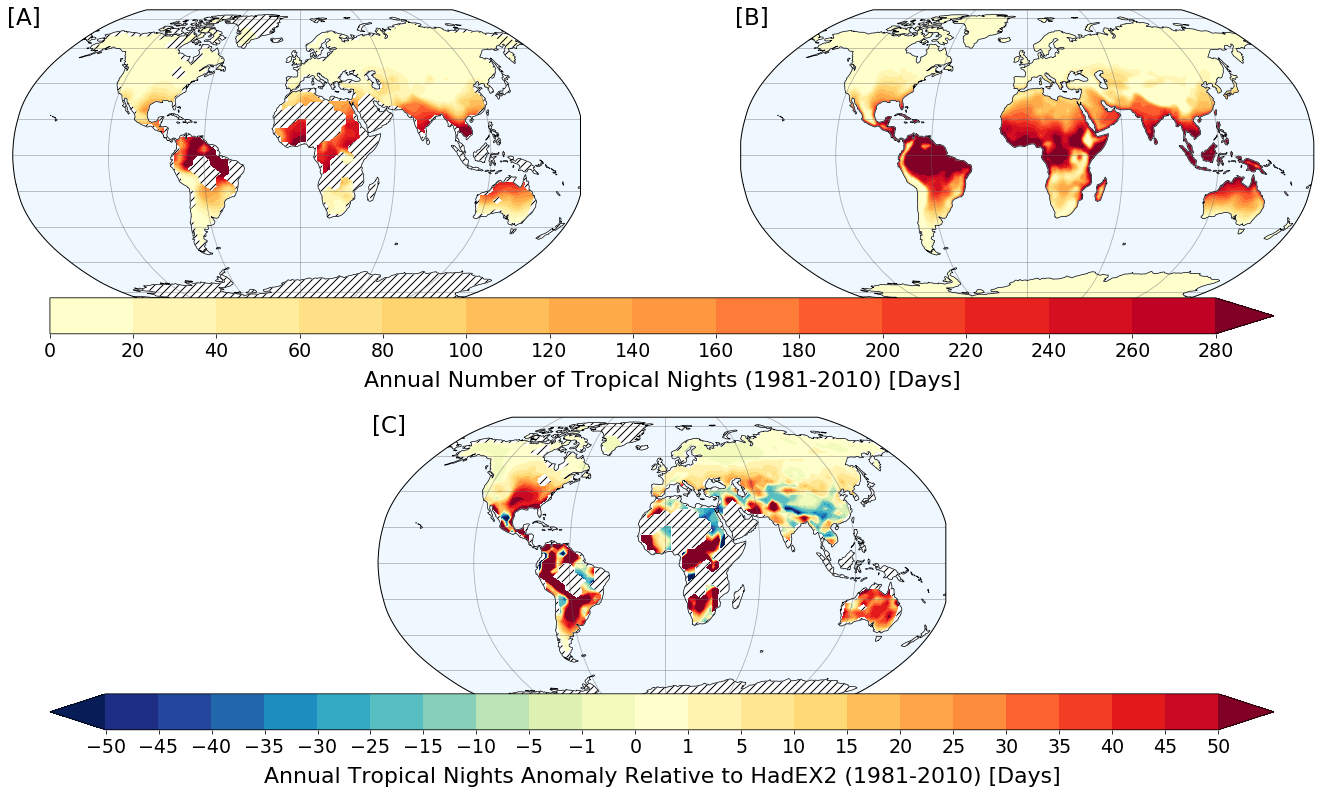

In [50]:
# define map projections and transformations
projection = ccrs.Robinson() # use Robinson projection
transform = ccrs.PlateCarree() # transform from PlateCarree projection

# define figure fontsizes
plot_label_fs = 23
plot_header_fs = 24
tick_label_fs = 19
axis_title_fs = 22

# create overall figure and base subplots
fig = plt.figure(figsize = (20, 10), constrained_layout = False) # longer than should be as additional colourbar
gs = fig.add_gridspec(nrows = 2, ncols = 4)

# create 1x2 grid across first row of the main base grid
gs_a = gs[0: 1, 0: 4].subgridspec(nrows = 1, ncols = 2)
axs1 = fig.add_subplot(gs_a[0, 0], projection = projection)
axs2 = fig.add_subplot(gs_a[0, 1], projection = projection)

# create a 1x1 grid across inner portion of the second row of the main base grid
gs_b = gs[1: 2, 1: 3].subgridspec(nrows = 1, ncols = 1)
axs3 = fig.add_subplot(gs_b[0, 0], projection = projection)

# define an axes list
axes = axs1, axs2, axs3

# create subplot bases
plot_labels = ['[A]', '[B]', '[C]']
for i, axs in enumerate(axes):
    axs.coastlines(color = 'black', resolution = '110m', lw = 0.7, zorder = 2)
    axs.gridlines(color = 'dimgrey', alpha = 0.5, zorder = 2)
    axs.add_feature(cartopy.feature.OCEAN, facecolor = 'aliceblue', zorder = 1)
    axs.text(x = 0.02, y = 0.95, s = plot_labels[i], fontsize = plot_label_fs,
             horizontalalignment = 'center', transform = axs.transAxes)

# adjust position of subplots to make space for a colourbar and reduce whitespacing
fig.subplots_adjust(bottom = 0.03, top = 1, left = 0., right = 1., wspace = 0.03, hspace = 0.4)


########## annual tropical nights: HadEX2 and multi-model ensemble ##########


# define bounds to group data with; each bin will then be normalised and mapped to a specific colour
bnds1 = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 370])

# create custom colourmap; obtain a list of RGB values for each colour to be mapped to
colour_list1 = plt.cm.get_cmap('YlOrRd', len(bnds1))
colours1 = colour_list1(np.arange(len(bnds1)))
colours1 = list(colours1)

# create custom colourmap; set colours of values exceeding contour levels set
cmap1 = colors.ListedColormap(colours1[0 :-1], '') # create colourmap object from specified colours
cmap1.set_over(colours1[-1]) # set colour of values exceeding upper contour value
norm1 = colors.BoundaryNorm(boundaries = bnds1,
                            ncolors = len(bnds1) - 1, # colours available to map too; out of bounds do not count
                            clip = False) 

# define the levels/contours for the subplots
lvls1 = np.array([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280])

# plot annual tropical night datasets; map first to colour bar to use later
cm1 = axs1.contourf(hadex2_ds.lon, hadex2_ds.lat, hadex2_ds, # [model: lat: lon]
                    transform = transform, levels = lvls1, norm = norm1,
                    cmap = cmap1, extend = 'max')
axs2.contourf(ens_ds.lon, ens_ds.lat, ens_ds,
              transform = transform, levels = lvls1, norm = norm1,
              cmap = cmap1, extend = 'max')

# plot areas with data equal missing data with hatches;
axs1.contourf(hadex2_ds.lon, hadex2_ds.lat, 
              hadex2_ds.where(hadex2_ds.fillna(-999) != -999, -999),
              transform = transform, alpha = 0, # set plot completely transparent
              levels = np.array([-999, hadex2_ds.min()]), # anything above min value not hatched
              extend = 'max', hatches = ['///', None])

# add colourbar
cb_axs1 = fig.add_axes([0.075, 0.55, 0.85, 0.05]) # add an axes to plot colourbar on; [left, bottom, width, height]
cbar1 = fig.colorbar(cm1, cax = cb_axs1, extend = 'max',
                     orientation = 'horizontal', ticks = lvls1)
cbar1.ax.tick_params(labelsize = tick_label_fs)
cbar1.set_label(label = f'Annual Number of Tropical Nights (1981-2010) [Days]',
                fontsize = axis_title_fs, rotation = 0, labelpad = 10)


########## ensemble annual tropical nights anomaly relative to HadEX2 ##########


# define bounds to group data with; each bin will then be normalised and mapped to a specific colour
bnds2 = np.array([-750, -50, -45, -40, -35, -30, -25, -15, -10, -5, -1, -0,
                  1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 750]) # outer bounds for anomaly larger

# count number of negative and postive bound values
neg_bnds2 = sum(1 for i in bnds2 if i < 0)
pos_bnds2 = len(bnds2) - neg_bnds2

# create custom colourmap; obtain a list of RGB values for each colour to be mapped to
pos_colour_list2 = plt.cm.get_cmap('YlOrRd', pos_bnds2)
neg_colour_list2 = plt.cm.get_cmap('YlGnBu_r', neg_bnds2 + 1) # so can exclude additional colour to match 
colours2 = np.vstack((neg_colour_list2(np.arange(neg_bnds2 + 1))[: -1], # exclude additional colour
                      pos_colour_list2(np.arange(pos_bnds2))))
colours2 = list(colours2)

# create custom colourmap; set colours of values exceeding contour levels set
cmap2 = colors.ListedColormap(colours2[1 :-1], '') # create colourmap object from specified colours
cmap2.set_over(colours2[-1]) # set colour of values exceeding upper contour value
cmap2.set_under(colours2[0]) # set colours of values exceeding lower contour value
norm2 = colors.BoundaryNorm(boundaries = bnds2,
                            ncolors = len(bnds2) - 2, # colours available to map too; out of bounds do not count
                            clip = False) 

# define the levels/contours for the subplots
lvls2 = np.array([-50, -45, -40, -35, -30, -25, -15, -10, -5, -1, -0,
                  1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

# plot annual tropical night anomalies; map first to colour bar to use later
cm2 = axs3.contourf(obs_anom_ds.lon, obs_anom_ds.lat, obs_anom_ds.ens_HadEX2_anom, # [model: lat: lon]
                    transform = transform, levels = lvls2, norm = norm2,
                    cmap = cmap2, extend = 'both')

# plot areas with missing data with hatches;
axs3.contourf(obs_anom_ds.lon, obs_anom_ds.lat, 
              obs_anom_ds.ens_HadEX2_anom.where(obs_anom_ds.ens_HadEX2_anom.fillna(-999) != -999, -999), 
              transform = transform, alpha = 0, # set plot completely transparent
              levels = np.array([-999, obs_anom_ds.ens_HadEX2_anom.min()]), # anything above min value not hatched
              extend = 'max', hatches = ['///', None])

# add colourbar
cb_axs2 = fig.add_axes([0.075, 0.0, 0.85, 0.05]) # add an axes to plot colourbar on; [left, bottom, width, height]
cbar2 = fig.colorbar(cm2, cax = cb_axs2, extend = 'both',
                     orientation = 'horizontal', ticks = lvls2)
cbar2.ax.tick_params(labelsize = tick_label_fs)
cbar2.set_label(label = f'Annual Tropical Nights Anomaly Relative to HadEX2 (1981-2010) [Days]',
                fontsize = axis_title_fs, rotation = 0, labelpad = 10)


### try conservative gridding; different colour scale too for error

In [ ]:
warm in tropics as less stations o intepolation to generate the HadEX2 dataset less confidence

In [139]:
# load data for figure
rmse_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/rmse_dictionary.pkl'
with open(rmse_pw, 'rb') as f:
    rmse_dict = pickle.load(f)
rel_rmse_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/rmse_dictionary.pkl'
with open(rel_rmse_pw, 'rb') as f:
    rel_rmse_dict = pickle.load(f)
    
    

{'BCC-CSM2-MR': -0.004716094784319541,
 'CanESM5': -0.014978498835995146,
 'CNRM-CM6-1': -0.037217540800629924,
 'ACCESS-ESM1-5': 0.14051785899338304,
 'ACCESS-CM2': -0.02140843250904083,
 'INM-CM4-8': -0.1139999583143938,
 'INM-CM5-0': -0.12162758239095187,
 'IPSL-CM6A-LR': -0.014135427999972694,
 'MIROC6': 0.3808522981994227,
 'UKESM1-0-LL': 0.010605059960163225,
 'MRI-ESM2-0': 0.13347527378923404,
 'NorESM2-MM': 0.15222807190088664,
 'AWI-CM-1-1-MR': 0.3116798818568606,
 'GFDL-ESM4': 0.0,
 'MPI-ESM1-2-HR': 0.2979074011359383,
 'ensemble': -0.10737829949184362}

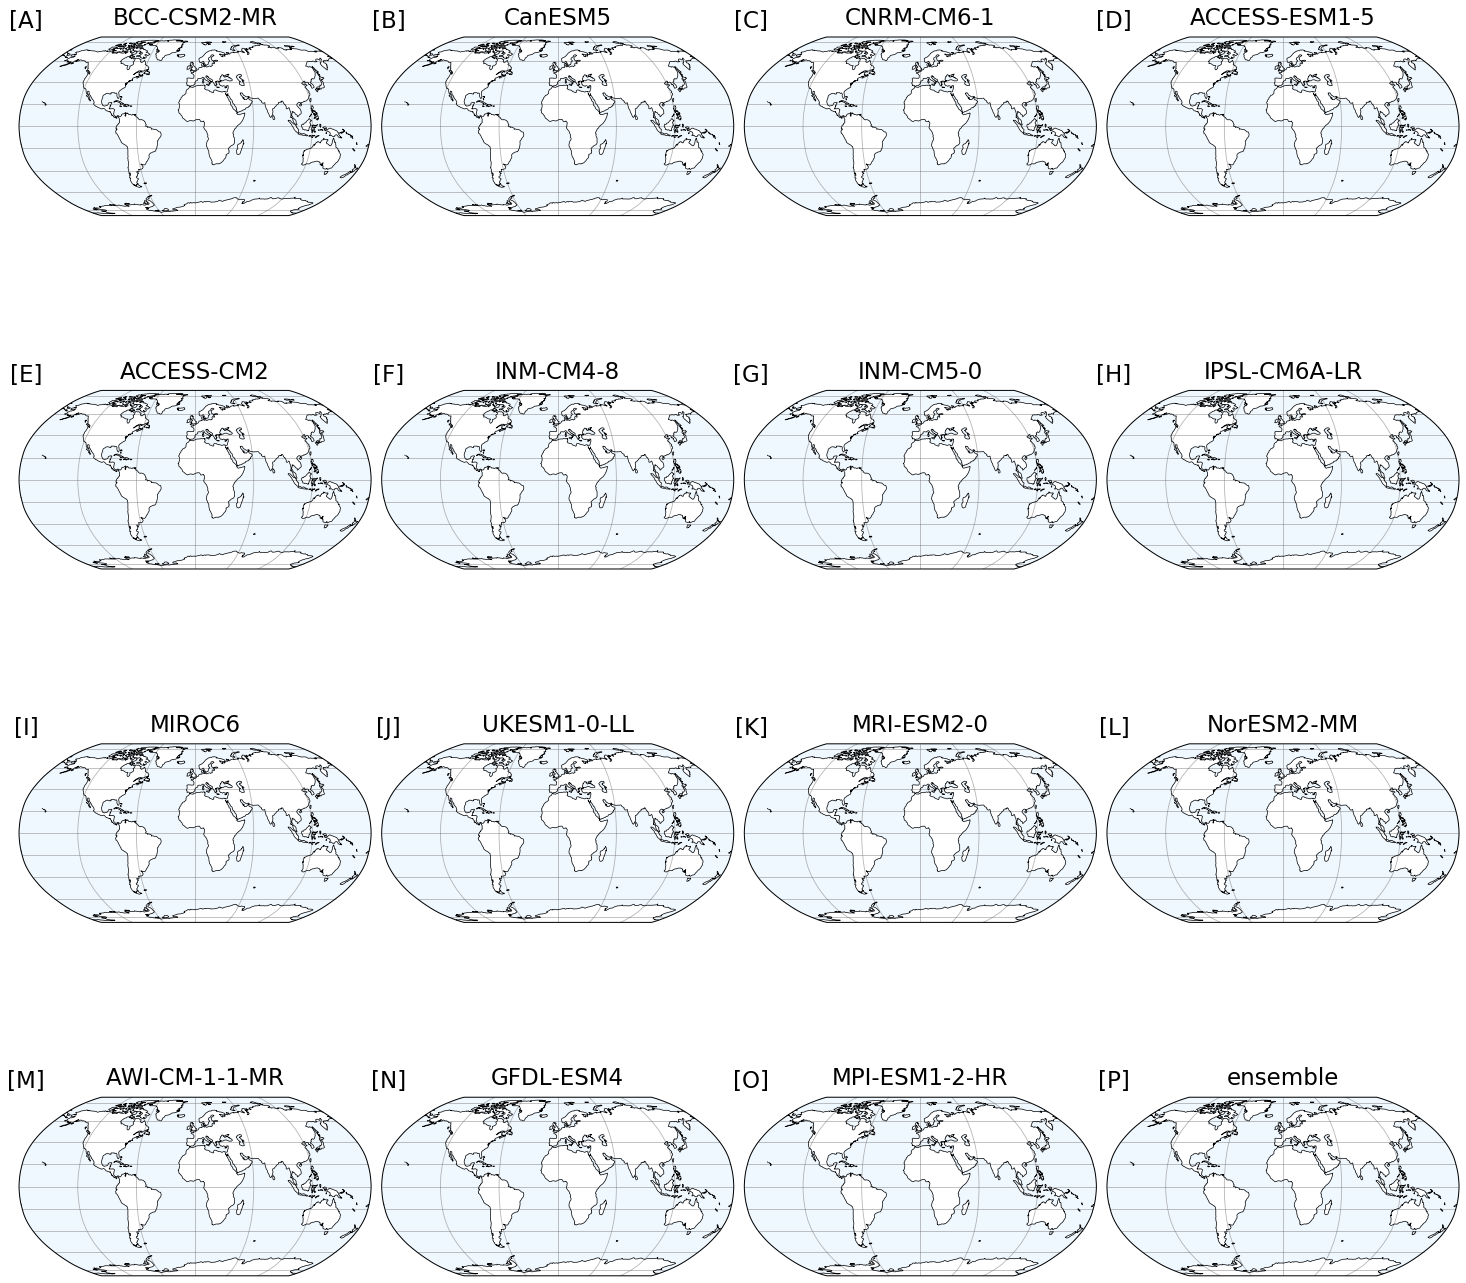

In [142]:
# define map projections and transformations
projection = ccrs.Robinson() # use Robinson projection
transform = ccrs.PlateCarree() # transform from PlateCarree projection

# define figure fontsizes
axis_title_fs = 24
plot_label_fs = 23
tick_label_fs = 23

# create figure and axes objects
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (20, 20),
                         subplot_kw = {'projection': projection})
axes = axes.flatten(order = 'C') # flatten to a 1D array

# create subplot bases
titles = list(rmse_dict.keys()) # define list of model names used
label = ['[A]', '[B]', '[C]', '[D]', '[E]', '[F]', '[G]', '[H]', '[I]', '[J]',
         '[K]', '[L]', '[M]', '[N]', '[O]', '[P]']
for i, axs in enumerate(axes):
    axs.coastlines(color = 'black', resolution = '110m', lw = 0.7, zorder = 2)
    axs.gridlines(color = 'dimgrey', alpha = 0.5, zorder = 2)
    axs.add_feature(cartopy.feature.OCEAN, facecolor = 'aliceblue', zorder = 1)
    axs.set_title(titles[i], fontsize = plot_label_fs, pad = 12)
    axs.text(x = 0.02, y = 1.05, s = label[i], fontsize = plot_label_fs, 
             horizontalalignment = 'center', transform = axs.transAxes)
    
# adjust position of subplots to make space for a colourbar and reduce whitespacing
fig.subplots_adjust(bottom = 0.03, top = 1, left = 0., right = 1., wspace = 0.03, hspace = 0.05)


########## model observational anomalies ###########

# define bounds to group data with; each bin will then be normalised and mapped to a specific colour
bnds1 = np.array([-750, -50, -45, -40, -35, -30, -25, -15, -10, -5, -1, -0,
                  1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 750]) # outer bounds for anomaly larger

# count number of negative and postive bound values
neg_bnds1 = sum(1 for i in bnds1 if i < 0)
pos_bnds1 = len(bnds1) - neg_bnds1

# create custom colourmap; obtain a list of RGB values for each colour to be mapped to
pos_colour_list1 = plt.cm.get_cmap('YlOrRd', pos_bnds1)
neg_colour_list1 = plt.cm.get_cmap('YlGnBu_r', neg_bnds1 + 1) # so can exclude additional colour to match 
colours1 = np.vstack((neg_colour_list1(np.arange(neg_bnds1 + 1))[: -1], # exclude additional colour
                      pos_colour_list1(np.arange(pos_bnds1))))
colours1 = list(colours1)

# create custom colourmap; set colours of values exceeding contour levels set
cmap1 = colors.ListedColormap(colours1[1 :-1], '') # create colourmap object from specified colours
cmap1.set_over(colours1[-1]) # set colour of values exceeding upper contour value
cmap1.set_under(colours1[0]) # set colours of values exceeding lower contour value
norm1 = colors.BoundaryNorm(boundaries = bnds1,
                            ncolors = len(bnds1) - 2, # colours available to map too; out of bounds do not count
                            clip = False) 

# define the levels/contours for the subplots
lvls1 = np.array([-50, -45, -40, -35, -30, -25, -15, -10, -5, -1, -0,
                  1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
    
